# TOPO 1 Matching is done automatically by the blockchain network
The matching logic is executed in the chaincode.

## Setup code

In [1]:
#Library Setup
from time import clock
import sys
sys.path.append("/home/utsav_jain/RenewThesis/fabric/organ_chain")
from log_analysis import PeerContainer, get_time, time_to_commit, set_blocks_info
#Graphs
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

peer_names=["peer0.gp.organ.com",
          "peer1.gp.organ.com",
           "peer0.histocompatibility.organ.com",
           "peer1.histocompatibility.organ.com",
           "peer0.opo.organ.com",
           "peer1.opo.organ.com",
           "peer0.hospital.organ.com",
           "peer1.hospital.organ.com"]

class TxnTimes:
    'This is txn times'
    def __init__(self, receive_time = 0, validate_time = 0, commmit_time = 0):
        self.receive_time = receive_time
        self.validate_time = validate_time
        self.commmit_time = commmit_time

class Block:
    def __init__(self, block_number):
        self.__name__ = str(block_number)
        self.block_number = block_number
        self.peers_times = {}
        
    def add_peer(self, peer_name, block_receive_time, block_validated_time, block_commited_time, verbose=False):
        '''
            This involves getting the block receive time, block validated time and the block commit time.
        '''

        t = TxnTimes(block_receive_time, block_validated_time, block_commited_time)
        
        self.peers_times[peer_name] = t
        if(verbose is True):
            print('Adding %s with rt %s, vt %s and ct %s' %(peer_name, block_receive_time, block_validated_time, block_commited_time))
        
    def get_longest_commit_time():
        largest = self.peer.itervalues().next()[2]
        for peer_id, time_array in self.peer:
            if(time_array[2]):
                pass
    def print_block_info():
        print("Block Number %s" % self.block_number)
        print("Peer Informa")
    
    def get_smallest_commit_time():
        pass
    
    def get_propogation_time(self, peers):
        commit_times = []
        receive_times = []
        for peer in self.peers_times:
            commit_times.append(self.peers_times[peer].commmit_time)
            receive_times.append(self.peers_times[peer].receive_time)
        max_commit_time = max(commit_times)
        min_receive_time = min(receive_times)
        return(max_commit_time - min_receive_time)

def get_propogation_times(log_files):
    '''
        STEPS:
            1. Setup the all_peers {}
            2. Extracct receive times
            3. Extract validation times
            4. Extract commit times
            5. Return Propogation times
    '''
    print("Starting STEP 1: Setup the all_peers dict")
    all_peers = {}
    for container in peer_names:
        
        start = clock()
        all_peers[container] = PeerContainer(str(container), log_files[container])
        set_blocks_info(all_peers[container])
        delta = clock() - start
        print("\t Set logs for %s in %s Sec" % (container, delta))
        
    print("Starting Step 2: Extract receive times.")
    
    # Adding block received times to the PeerContainer object
    start = 0
    start = clock()
    for peer in peer_names:
        l = ((all_peers[peer].find_received_block()))
#         print('\tThere are %s Recevied Lines in %s' % (len(l), peer))
        number_of_blocks = len(l)
        for line in l:
            pattern = 'Received block ['
            start = line['log'].find(pattern)
            if start == -1:
                continue
            x = line['log'][start + len(pattern):]
            end = x.find(']')
            if end == -1:
                continue
            block_number = x[:end]
            time = get_time(line)
            all_peers[peer].block_times[int(block_number)] = [time]
    delta = clock() - start
    print("\t Done Extracting Receive Times in %s Sec" % (delta))
    print("Stating Step 3: Extract validation times.")
    start = 0
    start = clock()
    for peer in peer_names:
        l = ((all_peers[peer].find_validated_block()))
#         print('\tThere are %s Validated Lines in %s' % (len(l), peer))
        number_of_blocks = len(l)
        for line in l:
            pattern = 'Validated block ['
            start = line['log'].find(pattern)
            if start == -1:
                continue
            x = line['log'][start + len(pattern):]
            end = x.find(']')
            if end == -1:
                continue
            block_number = x[:end]
            time = get_time(line)
            try:
                all_peers[peer].block_times[int(block_number)].append(time)
            except:
                pass
    #         print('%s block was Validated at %s by peer %s' % (block_number, time, all_peers[peer].name))
    delta = clock() - start
    print("\t Done Extracting Validation Times in %s Sec" % (delta))
    print("Stating Step 4: Extract commit times.")
    start = 0
    start = clock()
    for peer in peer_names:
        l = ((all_peers[peer].find_commited_block()))
#         print('\tThere are %s Committed Line %s' % (len(l), peer))
        number_of_blocks = len(l)
        for line in l:
            pattern = 'Committed block ['
            start = line['log'].find(pattern)
            if start == -1:
                continue
            x = line['log'][start + len(pattern):]
            end = x.find(']')
            if end == -1:
                continue
            block_number = x[:end]
            time = get_time(line)
            try:
                all_peers[peer].block_times[int(block_number)].append(time)
            except:
                pass
    delta = clock() - start
    print("\t Done Extracting Validation Times in %s Sec" % (delta))
    print("Starting Step 5: Return Propogation Time")
    blocks = {}
    # print(all_peers)
    for j, peer in enumerate(all_peers):
        print("\t Processing %s" % peer)
    #     print(all_peers[peer].block_times)
    #     print(len(all_peers[peer].block_times))
        for i in range(1, len(all_peers[peer].block_times)):
            rt = all_peers[peer].block_times[i][0]
            vt = all_peers[peer].block_times[i][1]
            ct = all_peers[peer].block_times[i][2]
    #         print("rt %s; vt %s; ct %s"% (rt, vt, ct))
            if i not in blocks:
                blocks[i] = Block(i)
            blocks[i].add_peer(all_peers[peer].name, rt, vt, ct)
#         print(all_peers[peer].name)

    propogation_times = []
    for i in range(1, len(blocks)):
#         print('Propogation Time of %s is %s' % (i, blocks[i].get_propogation_time(all_peers[peer])))
        propogation_times.append(blocks[i].get_propogation_time(all_peers[peer]).total_seconds())
    print("Done")
    return(propogation_times)

# Experiment 1

In [2]:
experiment1Results = []

In [3]:
#Experiment 1 Effect of Time Out Duration
log_files = {}
base = "/home/utsav_jain/RenewThesis/data/1_exp/logs_2s"
for container in peer_names:
    log_files[container] = ('%s/%s.log'%(base,container))
# print log_files
propogation_time = get_propogation_times(log_files)
experiment1Results.append(propogation_time)

Starting STEP 1: Setup the all_peers dict
	 Set logs for peer0.gp.organ.com in 0.014371 Sec
	 Set logs for peer1.gp.organ.com in 0.012824 Sec
	 Set logs for peer0.histocompatibility.organ.com in 0.01492 Sec
	 Set logs for peer1.histocompatibility.organ.com in 0.012943 Sec
	 Set logs for peer0.opo.organ.com in 0.012402 Sec
	 Set logs for peer1.opo.organ.com in 0.013628 Sec
	 Set logs for peer0.hospital.organ.com in 0.013357 Sec
	 Set logs for peer1.hospital.organ.com in 0.012265 Sec
Starting Step 2: Extract receive times.
	 Done Extracting Receive Times in -91.734789 Sec
Stating Step 3: Extract validation times.
	 Done Extracting Validation Times in -95.397411 Sec
Stating Step 4: Extract commit times.
	 Done Extracting Validation Times in -91.065722 Sec
Starting Step 5: Return Propogation Time
	 Processing peer0.histocompatibility.organ.com
	 Processing peer1.histocompatibility.organ.com
	 Processing peer1.opo.organ.com
	 Processing peer0.gp.organ.com
	 Processing peer0.hospital.organ.c

In [4]:
#Experiment 1.1 Batch Time Out of 5 sec with transaction rate of 
log_files = {}
base = "/home/utsav_jain/RenewThesis/data/1_exp/logs_5s"
for container in peer_names:
    log_files[container] = ('%s/%s.log'%(base,container))
# print log_files
propogation_time = get_propogation_times(log_files)
experiment1Results.append(propogation_time)

Starting STEP 1: Setup the all_peers dict
	 Set logs for peer0.gp.organ.com in 0.016032 Sec
	 Set logs for peer1.gp.organ.com in 0.015498 Sec
	 Set logs for peer0.histocompatibility.organ.com in 0.015364 Sec
	 Set logs for peer1.histocompatibility.organ.com in 0.015263 Sec
	 Set logs for peer0.opo.organ.com in 0.019879 Sec
	 Set logs for peer1.opo.organ.com in 0.015896 Sec
	 Set logs for peer0.hospital.organ.com in 0.016292 Sec
	 Set logs for peer1.hospital.organ.com in 0.018513 Sec
Starting Step 2: Extract receive times.
	 Done Extracting Receive Times in -90.59816 Sec
Stating Step 3: Extract validation times.
	 Done Extracting Validation Times in -94.298452 Sec
Stating Step 4: Extract commit times.
	 Done Extracting Validation Times in -89.997704 Sec
Starting Step 5: Return Propogation Time
	 Processing peer0.histocompatibility.organ.com
	 Processing peer1.histocompatibility.organ.com
	 Processing peer1.opo.organ.com
	 Processing peer0.gp.organ.com
	 Processing peer0.hospital.organ.c

In [5]:
#Experiment 1.3 Batch Time Out of 5 sec with transaction rate of
log_files = {}
base = "/home/utsav_jain/RenewThesis/data/1_exp/logs_10s"
for container in peer_names:
    log_files[container] = ('%s/%s.log'%(base,container))
# print log_files
propogation_time = get_propogation_times(log_files)
experiment1Results.append(propogation_time)

Starting STEP 1: Setup the all_peers dict
	 Set logs for peer0.gp.organ.com in 0.012939 Sec
	 Set logs for peer1.gp.organ.com in 0.014117 Sec
	 Set logs for peer0.histocompatibility.organ.com in 0.012592 Sec
	 Set logs for peer1.histocompatibility.organ.com in 0.013499 Sec
	 Set logs for peer0.opo.organ.com in 0.013458 Sec
	 Set logs for peer1.opo.organ.com in 0.013405 Sec
	 Set logs for peer0.hospital.organ.com in 0.013385 Sec
	 Set logs for peer1.hospital.organ.com in 0.012329 Sec
Starting Step 2: Extract receive times.
	 Done Extracting Receive Times in -89.496291 Sec
Stating Step 3: Extract validation times.
	 Done Extracting Validation Times in -93.179266 Sec
Stating Step 4: Extract commit times.
	 Done Extracting Validation Times in -88.861775 Sec
Starting Step 5: Return Propogation Time
	 Processing peer0.histocompatibility.organ.com
	 Processing peer1.histocompatibility.organ.com
	 Processing peer1.opo.organ.com
	 Processing peer0.gp.organ.com
	 Processing peer0.hospital.organ.

In [6]:
#Experiment 1.4 Batch Time Out of 5 sec with transaction rate of
log_files = {}
base = "/home/utsav_jain/RenewThesis/data/1_exp/logs_15s"
for container in peer_names:
    log_files[container] = ('%s/%s.log'%(base,container))
# print log_files
propogation_time = get_propogation_times(log_files)
experiment1Results.append(propogation_time)

Starting STEP 1: Setup the all_peers dict
	 Set logs for peer0.gp.organ.com in 0.030039 Sec
	 Set logs for peer1.gp.organ.com in 0.032203 Sec
	 Set logs for peer0.histocompatibility.organ.com in 0.030938 Sec
	 Set logs for peer1.histocompatibility.organ.com in 0.031026 Sec
	 Set logs for peer0.opo.organ.com in 0.030296 Sec
	 Set logs for peer1.opo.organ.com in 0.031301 Sec
	 Set logs for peer0.hospital.organ.com in 0.031815 Sec
	 Set logs for peer1.hospital.organ.com in 0.03038 Sec
Starting Step 2: Extract receive times.
	 Done Extracting Receive Times in -88.447065 Sec
Stating Step 3: Extract validation times.
	 Done Extracting Validation Times in -92.320268 Sec
Stating Step 4: Extract commit times.
	 Done Extracting Validation Times in -88.186623 Sec
Starting Step 5: Return Propogation Time
	 Processing peer0.histocompatibility.organ.com
	 Processing peer1.histocompatibility.organ.com
	 Processing peer1.opo.organ.com
	 Processing peer0.gp.organ.com
	 Processing peer0.hospital.organ.c

# Experiment 2

Experiment 2 
Steps
1. Read the log files for each peer
2. Extract Lines
    2.1 Received Lines
    2.2 Validated Lines
    2.3 Commited Lines
3. Find the propogation time 
4. Make graphs


In [7]:
experiment2Results =[]

In [8]:
#Experiment 2.1
log_files = {}
base = "/home/utsav_jain/RenewThesis/data/2_exp/logs_2_1"
for container in peer_names:
    log_files[container] = ('%s/%s.log'%(base,container))
# print log_files
propogation_time = get_propogation_times(log_files)
experiment2Results.append(propogation_time)

Starting STEP 1: Setup the all_peers dict
	 Set logs for peer0.gp.organ.com in 0.013618 Sec
	 Set logs for peer1.gp.organ.com in 0.0122 Sec
	 Set logs for peer0.histocompatibility.organ.com in 0.013827 Sec
	 Set logs for peer1.histocompatibility.organ.com in 0.012708 Sec
	 Set logs for peer0.opo.organ.com in 0.012209 Sec
	 Set logs for peer1.opo.organ.com in 0.012303 Sec
	 Set logs for peer0.hospital.organ.com in 0.015282 Sec
	 Set logs for peer1.hospital.organ.com in 0.012782 Sec
Starting Step 2: Extract receive times.
	 Done Extracting Receive Times in -87.695067 Sec
Stating Step 3: Extract validation times.
	 Done Extracting Validation Times in -91.356692 Sec
Stating Step 4: Extract commit times.
	 Done Extracting Validation Times in -87.018406 Sec
Starting Step 5: Return Propogation Time
	 Processing peer0.histocompatibility.organ.com
	 Processing peer1.histocompatibility.organ.com
	 Processing peer1.opo.organ.com
	 Processing peer0.gp.organ.com
	 Processing peer0.hospital.organ.co

In [9]:
#Experiment 2.2
log_files = {}
base = "/home/utsav_jain/RenewThesis/data/2_exp/logs_2_2"
for container in peer_names:
    log_files[container] = ('%s/%s.log'%(base,container))
# print log_files
propogation_time = get_propogation_times(log_files)
experiment2Results.append(propogation_time)

Starting STEP 1: Setup the all_peers dict
	 Set logs for peer0.gp.organ.com in 0.013555 Sec
	 Set logs for peer1.gp.organ.com in 0.01146 Sec
	 Set logs for peer0.histocompatibility.organ.com in 0.011885 Sec
	 Set logs for peer1.histocompatibility.organ.com in 0.011984 Sec
	 Set logs for peer0.opo.organ.com in 0.01232 Sec
	 Set logs for peer1.opo.organ.com in 0.01147 Sec
	 Set logs for peer0.hospital.organ.com in 0.0436 Sec
	 Set logs for peer1.hospital.organ.com in 0.012186 Sec
Starting Step 2: Extract receive times.
	 Done Extracting Receive Times in -86.515208 Sec
Stating Step 3: Extract validation times.
	 Done Extracting Validation Times in -90.186296 Sec
Stating Step 4: Extract commit times.
	 Done Extracting Validation Times in -85.8543 Sec
Starting Step 5: Return Propogation Time
	 Processing peer0.histocompatibility.organ.com
	 Processing peer1.histocompatibility.organ.com
	 Processing peer1.opo.organ.com
	 Processing peer0.gp.organ.com
	 Processing peer0.hospital.organ.com
	 P

In [10]:
#Experiment 2.3
log_files = {}
base = "/home/utsav_jain/RenewThesis/data/2_exp/logs_2_3"
for container in peer_names:
    log_files[container] = ('%s/%s.log'%(base,container))
# print log_files
propogation_time = get_propogation_times(log_files)
experiment2Results.append(propogation_time)

Starting STEP 1: Setup the all_peers dict
	 Set logs for peer0.gp.organ.com in 0.014108 Sec
	 Set logs for peer1.gp.organ.com in 0.013247 Sec
	 Set logs for peer0.histocompatibility.organ.com in 0.013456 Sec
	 Set logs for peer1.histocompatibility.organ.com in 0.011645 Sec
	 Set logs for peer0.opo.organ.com in 0.012414 Sec
	 Set logs for peer1.opo.organ.com in 0.012043 Sec
	 Set logs for peer0.hospital.organ.com in 0.013974 Sec
	 Set logs for peer1.hospital.organ.com in 0.018357 Sec
Starting Step 2: Extract receive times.
	 Done Extracting Receive Times in -85.359255 Sec
Stating Step 3: Extract validation times.
	 Done Extracting Validation Times in -89.032951 Sec
Stating Step 4: Extract commit times.
	 Done Extracting Validation Times in -84.710379 Sec
Starting Step 5: Return Propogation Time
	 Processing peer0.histocompatibility.organ.com
	 Processing peer1.histocompatibility.organ.com
	 Processing peer1.opo.organ.com
	 Processing peer0.gp.organ.com
	 Processing peer0.hospital.organ.

In [11]:
#Experiment 2.4
log_files = {}
base = "/home/utsav_jain/RenewThesis/data/2_exp/logs_2_4"
for container in peer_names:
    log_files[container] = ('%s/%s.log'%(base,container))
# print log_files
propogation_time = get_propogation_times(log_files)
experiment2Results.append(propogation_time)

Starting STEP 1: Setup the all_peers dict
	 Set logs for peer0.gp.organ.com in 0.012373 Sec
	 Set logs for peer1.gp.organ.com in 0.011057 Sec
	 Set logs for peer0.histocompatibility.organ.com in 0.01146 Sec
	 Set logs for peer1.histocompatibility.organ.com in 0.010783 Sec
	 Set logs for peer0.opo.organ.com in 0.011106 Sec
	 Set logs for peer1.opo.organ.com in 0.011724 Sec
	 Set logs for peer0.hospital.organ.com in 0.015535 Sec
	 Set logs for peer1.hospital.organ.com in 0.010811 Sec
Starting Step 2: Extract receive times.
	 Done Extracting Receive Times in -84.257877 Sec
Stating Step 3: Extract validation times.
	 Done Extracting Validation Times in -87.921689 Sec
Stating Step 4: Extract commit times.
	 Done Extracting Validation Times in -83.596543 Sec
Starting Step 5: Return Propogation Time
	 Processing peer0.histocompatibility.organ.com
	 Processing peer1.histocompatibility.organ.com
	 Processing peer1.opo.organ.com
	 Processing peer0.gp.organ.com
	 Processing peer0.hospital.organ.c

# Experiment 3

In [12]:
experiment3Results =[]

In [13]:
#Experiment 3.1
log_files = {}
base = "/home/utsav_jain/RenewThesis/data/3_exp/logs_3_1"
for container in peer_names:
    log_files[container] = ('%s/%s.log'%(base,container))
# print log_files
propogation_time = get_propogation_times(log_files)
print("The length of propogation time is %s" % len(propogation_time))
experiment3Results.append(propogation_time)

Starting STEP 1: Setup the all_peers dict
	 Set logs for peer0.gp.organ.com in 0.013619 Sec
	 Set logs for peer1.gp.organ.com in 0.010995 Sec
	 Set logs for peer0.histocompatibility.organ.com in 0.011409 Sec
	 Set logs for peer1.histocompatibility.organ.com in 0.010967 Sec
	 Set logs for peer0.opo.organ.com in 0.012865 Sec
	 Set logs for peer1.opo.organ.com in 0.011689 Sec
	 Set logs for peer0.hospital.organ.com in 0.012281 Sec
	 Set logs for peer1.hospital.organ.com in 0.011183 Sec
Starting Step 2: Extract receive times.
	 Done Extracting Receive Times in -83.136039 Sec
Stating Step 3: Extract validation times.
	 Done Extracting Validation Times in -86.806998 Sec
Stating Step 4: Extract commit times.
	 Done Extracting Validation Times in -82.477185 Sec
Starting Step 5: Return Propogation Time
	 Processing peer0.histocompatibility.organ.com
	 Processing peer1.histocompatibility.organ.com
	 Processing peer1.opo.organ.com
	 Processing peer0.gp.organ.com
	 Processing peer0.hospital.organ.

In [14]:
#Experiment 3.2
log_files = {}
base = "/home/utsav_jain/RenewThesis/data/3_exp/logs_3_2"
for container in peer_names:
    log_files[container] = ('%s/%s.log'%(base,container))
# print log_files
propogation_time = get_propogation_times(log_files)
print("The length of propogation time is %s" % len(propogation_time))
experiment3Results.append(propogation_time)

Starting STEP 1: Setup the all_peers dict
	 Set logs for peer0.gp.organ.com in 0.012754 Sec
	 Set logs for peer1.gp.organ.com in 0.011425 Sec
	 Set logs for peer0.histocompatibility.organ.com in 0.013272 Sec
	 Set logs for peer1.histocompatibility.organ.com in 0.011475 Sec
	 Set logs for peer0.opo.organ.com in 0.011513 Sec
	 Set logs for peer1.opo.organ.com in 0.011324 Sec
	 Set logs for peer0.hospital.organ.com in 0.011742 Sec
	 Set logs for peer1.hospital.organ.com in 0.013541 Sec
Starting Step 2: Extract receive times.
	 Done Extracting Receive Times in -81.984169 Sec
Stating Step 3: Extract validation times.
	 Done Extracting Validation Times in -85.666677 Sec
Stating Step 4: Extract commit times.
	 Done Extracting Validation Times in -81.347515 Sec
Starting Step 5: Return Propogation Time
	 Processing peer0.histocompatibility.organ.com
	 Processing peer1.histocompatibility.organ.com
	 Processing peer1.opo.organ.com
	 Processing peer0.gp.organ.com
	 Processing peer0.hospital.organ.

In [15]:
#Experiment 3.3
log_files = {}
base = "/home/utsav_jain/RenewThesis/data/3_exp/logs_3_3"
for container in peer_names:
    log_files[container] = ('%s/%s.log'%(base,container))
# print log_files
propogation_time = get_propogation_times(log_files)
print("The length of propogation time is %s" % len(propogation_time))
experiment3Results.append(propogation_time)

Starting STEP 1: Setup the all_peers dict
	 Set logs for peer0.gp.organ.com in 0.012756 Sec
	 Set logs for peer1.gp.organ.com in 0.011456 Sec
	 Set logs for peer0.histocompatibility.organ.com in 0.011628 Sec
	 Set logs for peer1.histocompatibility.organ.com in 0.011269 Sec
	 Set logs for peer0.opo.organ.com in 0.012164 Sec
	 Set logs for peer1.opo.organ.com in 0.010948 Sec
	 Set logs for peer0.hospital.organ.com in 0.01297 Sec
	 Set logs for peer1.hospital.organ.com in 0.011073 Sec
Starting Step 2: Extract receive times.
	 Done Extracting Receive Times in -80.893784 Sec
Stating Step 3: Extract validation times.
	 Done Extracting Validation Times in -84.569771 Sec
Stating Step 4: Extract commit times.
	 Done Extracting Validation Times in -80.248599 Sec
Starting Step 5: Return Propogation Time
	 Processing peer0.histocompatibility.organ.com
	 Processing peer1.histocompatibility.organ.com
	 Processing peer1.opo.organ.com
	 Processing peer0.gp.organ.com
	 Processing peer0.hospital.organ.c

In [16]:
#Experiment 3.4
log_files = {}
base = "/home/utsav_jain/RenewThesis/data/3_exp/logs_3_4"
for container in peer_names:
    log_files[container] = ('%s/%s.log'%(base,container))
# print log_files
propogation_time = get_propogation_times(log_files)
print("The length of propogation time is %s" % len(propogation_time))
experiment3Results.append(propogation_time)

Starting STEP 1: Setup the all_peers dict
	 Set logs for peer0.gp.organ.com in 0.013356 Sec
	 Set logs for peer1.gp.organ.com in 0.011976 Sec
	 Set logs for peer0.histocompatibility.organ.com in 0.012311 Sec
	 Set logs for peer1.histocompatibility.organ.com in 0.011791 Sec
	 Set logs for peer0.opo.organ.com in 0.013916 Sec
	 Set logs for peer1.opo.organ.com in 0.012122 Sec
	 Set logs for peer0.hospital.organ.com in 0.011822 Sec
	 Set logs for peer1.hospital.organ.com in 0.011332 Sec
Starting Step 2: Extract receive times.
	 Done Extracting Receive Times in -79.773491 Sec
Stating Step 3: Extract validation times.
	 Done Extracting Validation Times in -83.443191 Sec
Stating Step 4: Extract commit times.
	 Done Extracting Validation Times in -79.114416 Sec
Starting Step 5: Return Propogation Time
	 Processing peer0.histocompatibility.organ.com
	 Processing peer1.histocompatibility.organ.com
	 Processing peer1.opo.organ.com
	 Processing peer0.gp.organ.com
	 Processing peer0.hospital.organ.

# Experiment 4

In [17]:
experiment4Results = []

In [18]:
#Experiment 4.1
log_files = {}
base = "/home/utsav_jain/RenewThesis/data/4_exp/logs_4_1"
for container in peer_names:
    log_files[container] = ('%s/%s.log'%(base,container))
# print log_files
propogation_time = get_propogation_times(log_files)
print("The length of propogation time is %s" % len(propogation_time))
experiment4Results.append(propogation_time)

Starting STEP 1: Setup the all_peers dict
	 Set logs for peer0.gp.organ.com in 0.01358 Sec
	 Set logs for peer1.gp.organ.com in 0.012232 Sec
	 Set logs for peer0.histocompatibility.organ.com in 0.01252 Sec
	 Set logs for peer1.histocompatibility.organ.com in 0.012593 Sec
	 Set logs for peer0.opo.organ.com in 0.012045 Sec
	 Set logs for peer1.opo.organ.com in 0.01253 Sec
	 Set logs for peer0.hospital.organ.com in 0.013221 Sec
	 Set logs for peer1.hospital.organ.com in 0.011908 Sec
Starting Step 2: Extract receive times.
	 Done Extracting Receive Times in -78.591746 Sec
Stating Step 3: Extract validation times.
	 Done Extracting Validation Times in -82.245351 Sec
Stating Step 4: Extract commit times.
	 Done Extracting Validation Times in -77.907075 Sec
Starting Step 5: Return Propogation Time
	 Processing peer0.histocompatibility.organ.com
	 Processing peer1.histocompatibility.organ.com
	 Processing peer1.opo.organ.com
	 Processing peer0.gp.organ.com
	 Processing peer0.hospital.organ.com

In [19]:
#Experiment 4.2
log_files = {}
base = "/home/utsav_jain/RenewThesis/data/4_exp/logs_4_2"
for container in peer_names:
    log_files[container] = ('%s/%s.log'%(base,container))
# print log_files
propogation_time = get_propogation_times(log_files)
print("The length of propogation time is %s" % len(propogation_time))
experiment4Results.append(propogation_time)

Starting STEP 1: Setup the all_peers dict
	 Set logs for peer0.gp.organ.com in 0.013367 Sec
	 Set logs for peer1.gp.organ.com in 0.011442 Sec
	 Set logs for peer0.histocompatibility.organ.com in 0.017174 Sec
	 Set logs for peer1.histocompatibility.organ.com in 0.012522 Sec
	 Set logs for peer0.opo.organ.com in 0.012165 Sec
	 Set logs for peer1.opo.organ.com in 0.01194 Sec
	 Set logs for peer0.hospital.organ.com in 0.012349 Sec
	 Set logs for peer1.hospital.organ.com in 0.012404 Sec
Starting Step 2: Extract receive times.
	 Done Extracting Receive Times in -77.424902 Sec
Stating Step 3: Extract validation times.
	 Done Extracting Validation Times in -81.081764 Sec
Stating Step 4: Extract commit times.
	 Done Extracting Validation Times in -76.7207 Sec
Starting Step 5: Return Propogation Time
	 Processing peer0.histocompatibility.organ.com
	 Processing peer1.histocompatibility.organ.com
	 Processing peer1.opo.organ.com
	 Processing peer0.gp.organ.com
	 Processing peer0.hospital.organ.com

In [20]:
#Experiment 4.3
log_files = {}
base = "/home/utsav_jain/RenewThesis/data/4_exp/logs_4_3"
for container in peer_names:
    log_files[container] = ('%s/%s.log'%(base,container))
# print log_files
propogation_time = get_propogation_times(log_files)
print("The length of propogation time is %s" % len(propogation_time))
experiment4Results.append(propogation_time)

Starting STEP 1: Setup the all_peers dict
	 Set logs for peer0.gp.organ.com in 0.013502 Sec
	 Set logs for peer1.gp.organ.com in 0.012045 Sec
	 Set logs for peer0.histocompatibility.organ.com in 0.013284 Sec
	 Set logs for peer1.histocompatibility.organ.com in 0.01176 Sec
	 Set logs for peer0.opo.organ.com in 0.012055 Sec
	 Set logs for peer1.opo.organ.com in 0.012017 Sec
	 Set logs for peer0.hospital.organ.com in 0.013441 Sec
	 Set logs for peer1.hospital.organ.com in 0.015864 Sec
Starting Step 2: Extract receive times.
	 Done Extracting Receive Times in -76.25731 Sec
Stating Step 3: Extract validation times.
	 Done Extracting Validation Times in -79.9238 Sec
Stating Step 4: Extract commit times.
	 Done Extracting Validation Times in -75.596509 Sec
Starting Step 5: Return Propogation Time
	 Processing peer0.histocompatibility.organ.com
	 Processing peer1.histocompatibility.organ.com
	 Processing peer1.opo.organ.com
	 Processing peer0.gp.organ.com
	 Processing peer0.hospital.organ.com


In [21]:
#Experiment 4.4
log_files = {}
base = "/home/utsav_jain/RenewThesis/data/4_exp/logs_4_4"
for container in peer_names:
    log_files[container] = ('%s/%s.log'%(base,container))
# print log_files
propogation_time = get_propogation_times(log_files)
print("The length of propogation time is %s" % len(propogation_time))
experiment4Results.append(propogation_time)

Starting STEP 1: Setup the all_peers dict
	 Set logs for peer0.gp.organ.com in 0.01229 Sec
	 Set logs for peer1.gp.organ.com in 0.011556 Sec
	 Set logs for peer0.histocompatibility.organ.com in 0.011575 Sec
	 Set logs for peer1.histocompatibility.organ.com in 0.012289 Sec
	 Set logs for peer0.opo.organ.com in 0.0118 Sec
	 Set logs for peer1.opo.organ.com in 0.012115 Sec
	 Set logs for peer0.hospital.organ.com in 0.012459 Sec
	 Set logs for peer1.hospital.organ.com in 0.011295 Sec
Starting Step 2: Extract receive times.
	 Done Extracting Receive Times in -75.127814 Sec
Stating Step 3: Extract validation times.
	 Done Extracting Validation Times in -78.791892 Sec
Stating Step 4: Extract commit times.
	 Done Extracting Validation Times in -74.462464 Sec
Starting Step 5: Return Propogation Time
	 Processing peer0.histocompatibility.organ.com
	 Processing peer1.histocompatibility.organ.com
	 Processing peer1.opo.organ.com
	 Processing peer0.gp.organ.com
	 Processing peer0.hospital.organ.com

# Experiment 1 Effect of Batch Time Out Interval

| Experiment     | Batch TimeOut (seconds) | Prefered Batch Size(KB) | Endorsement Policy | Transaction Rate |
|----------------|-------------------------|-------------------------|--------------------|------------------|
| Experiment 1.1 | 2                       | 8 KB                    | All AND            | 10               |
| Experiment 1.2 | 5                       | 8 KB                    | All AND            | 10               |
| Experiment 1.3 | 10                      | 8 KB                    | All AND            | 10               |
| Experiment 1.4 | 15                      | 8 KB                    | All AND            | 10               |

There are 203 Blocks


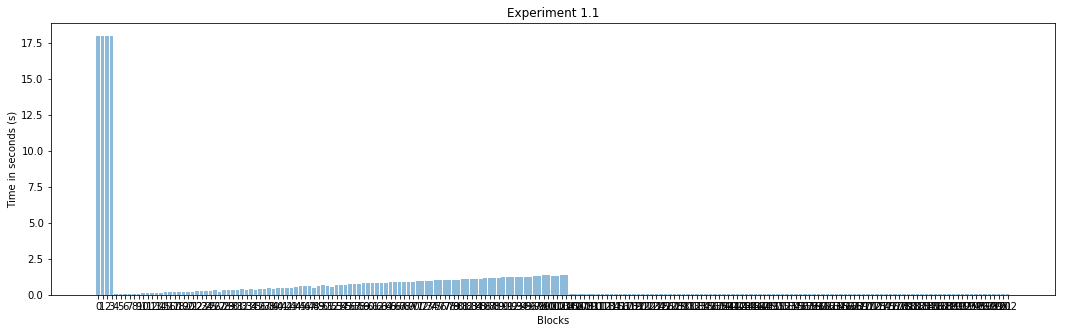

There are 181 Blocks


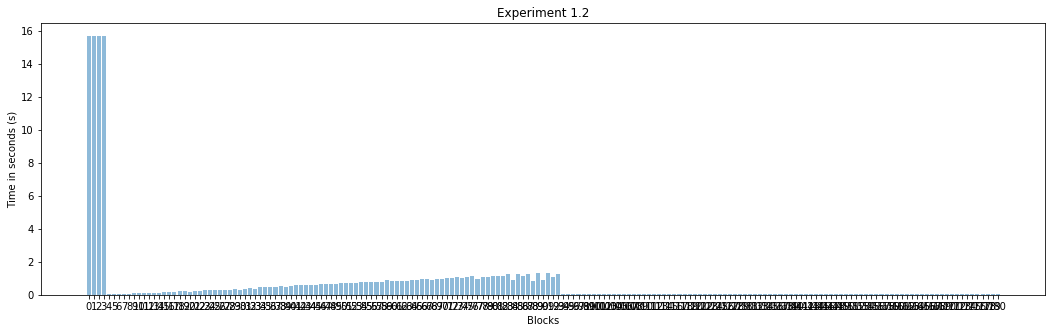

There are 201 Blocks


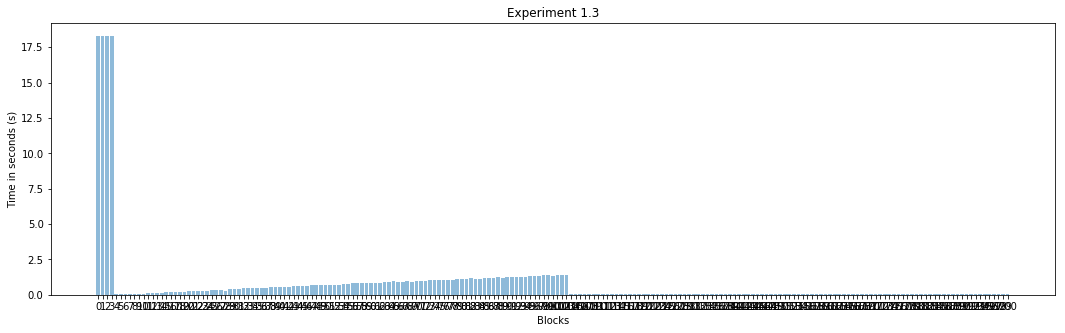

There are 69 Blocks


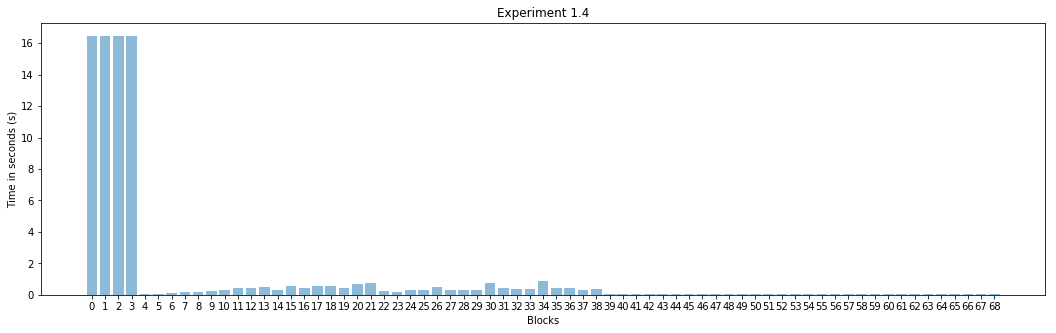

In [22]:
for j in range(1, 5):
    blocks = []
    print("There are %s Blocks"%len(experiment1Results[j-1]))
    for i in range(len(experiment1Results[j-1])):
        blocks.append(str(i))

    propogation_time= experiment1Results[j-1]
    y_pos = np.arange(len(propogation_time))
    # performance = [10,8,6,4,2,1]
    plt.subplots(figsize=(18,5))
    plt.bar(y_pos, propogation_time, width=.8, align='center', alpha=0.5 )
    plt.xticks(y_pos, blocks)
    plt.ylabel('Time in seconds (s)')
    plt.xlabel('Blocks')
    plt.title('Experiment 1.%s'% j)

    plt.show()

# Experiment 2 Effect of the Preferred Batch Size

| Experiment     | Batch Time Out (seconds) | Prefered Batch Size(KB) | Endorsement Policy | Transaction Rate |
|----------------|-------------------------|-------------------------|--------------------|------------------|
| Experiment 2.1 | 10                      | 8 KB                    | All AND            | 1 per 2 sec      |
| Experiment 2.2 | 10                      | 16 KB                   | All AND            | 1 per 2 sec      |
| Experiment 2.3 | 10                      | 32 KB                   | All AND            | 1 per 2 sec      |
| Experiment 2.4 | 10                      | 32 KB                   | All AND            | 1 per 5 sec      |

There are 203 Blocks


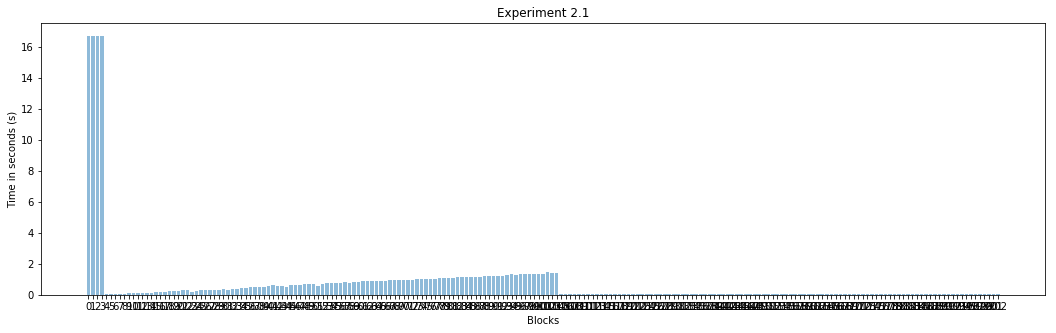

There are 203 Blocks


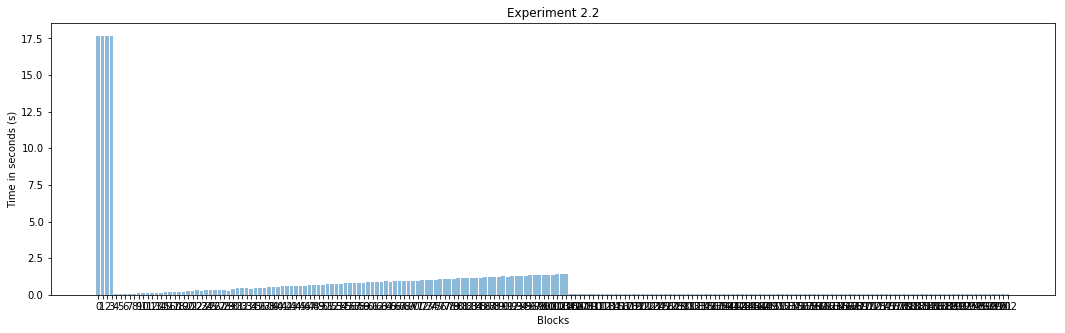

There are 203 Blocks


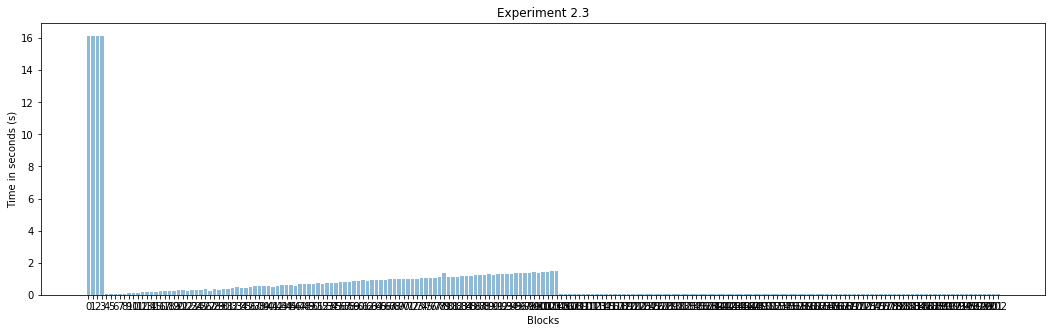

There are 203 Blocks


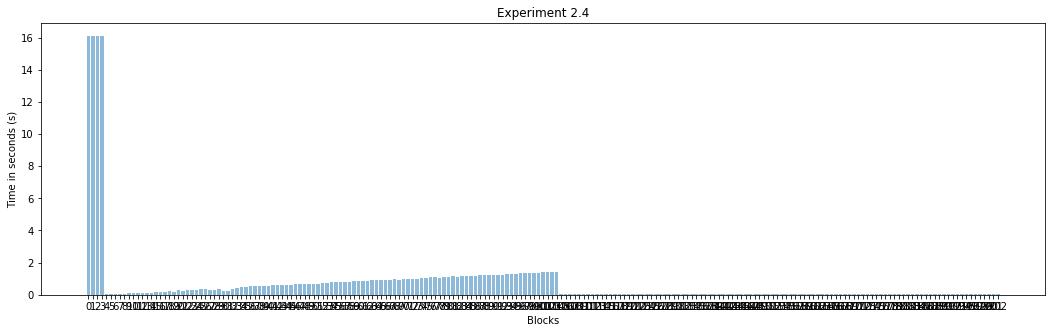

In [23]:
for j in range(1, 5):
    blocks = []
    print("There are %s Blocks"%len(experiment2Results[j-1]))
    for i in range(len(experiment2Results[j-1])):
        blocks.append(str(i))

    propogation_time= experiment2Results[j-1]
    y_pos = np.arange(len(propogation_time))
    # performance = [10,8,6,4,2,1]
    plt.subplots(figsize=(18,5))
    plt.bar(y_pos, propogation_time, width=.8, align='center', alpha=0.5 )
    plt.xticks(y_pos, blocks)
    plt.ylabel('Time in seconds (s)')
    plt.xlabel('Blocks')
    plt.title('Experiment 2.%s'% j)

    plt.show()

# Experiment 3 Effect of Endorsement Policy

| Experiment     | Batch TimeOut (seconds) | Prefered Batch Size(KB) | Endorsement Policy | Transaction Rate |
|----------------|-------------------------|-------------------------|--------------------|------------------|
| Experiment 3.1 | 10                      | 16 KB                   | All OR             | 1 per 5 sec      |
| Experiment 3.2 | 10                      | 16 KB                   | All AND            | 1 per 5 sec      |
| Experiment 3.3 | 10                      | 16 KB                   | 2 Out Of All       | 1 per 5 sec      |
| Experiment 3.4 | 10                      | 16 KB                   | 3 Out Of All       | 1 per 5 sec      |

There are 203 Blocks


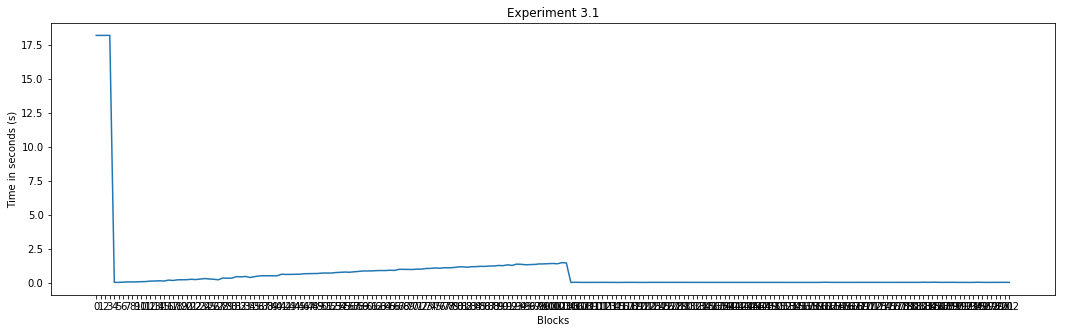

There are 203 Blocks


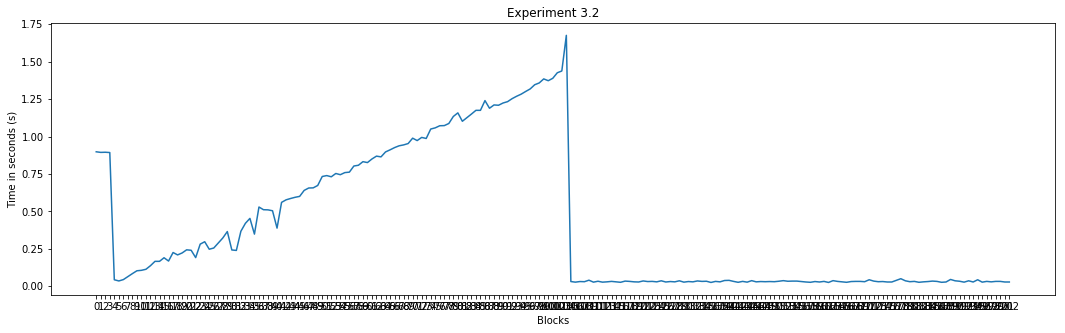

There are 203 Blocks


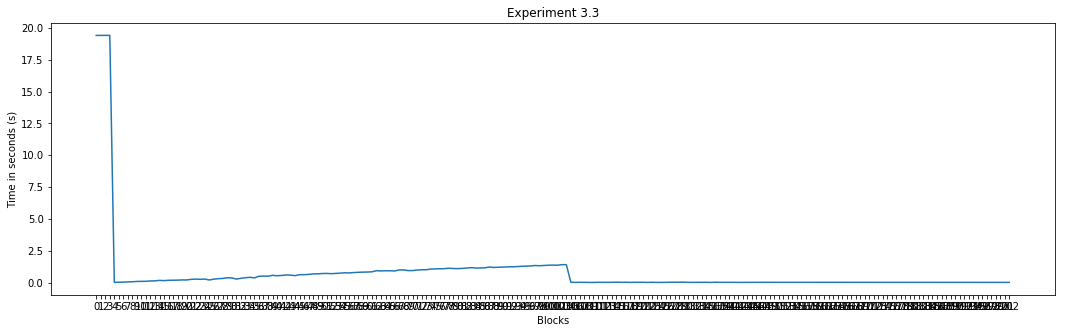

There are 203 Blocks


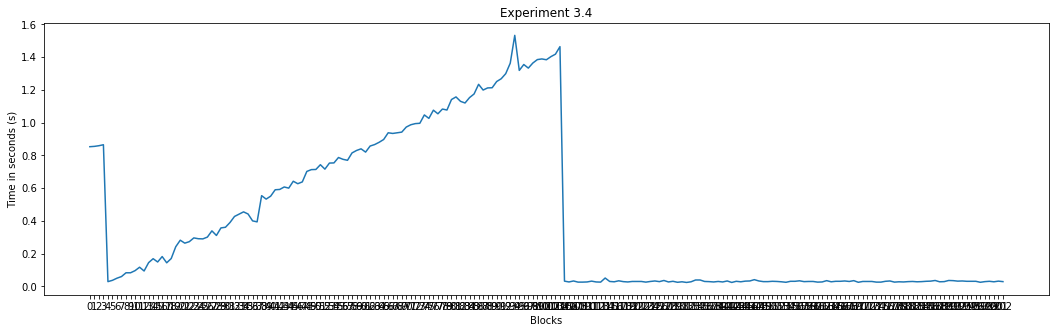

In [24]:
for j in range(1, 5):
    blocks = []
    print("There are %s Blocks"%len(experiment3Results[j-1]))
    for i in range(len(experiment3Results[j-1])):
        blocks.append(str(i))

    propogation_time= experiment3Results[j-1]
    y_pos = np.arange(len(propogation_time))
    # performance = [10,8,6,4,2,1]
    plt.subplots(figsize=(18,5))
#     plt.bar(y_pos, propogation_time, width=.8, align='center', alpha=0.5 )
    plt.plot(y_pos, propogation_time)
    plt.xticks(y_pos, blocks)
    plt.ylabel('Time in seconds (s)')
    plt.xlabel('Blocks')
    plt.title('Experiment 3.%s'% j)

    plt.show()

# Experiment 4 Effect Of Transaction Rate

| Experiment     | Batch TimeOut (seconds) | Prefered Batch Size(KB) | Endorsement Policy | Transaction Rate |
|----------------|-------------------------|-------------------------|--------------------|------------------|
| Experiment 4.1 | 10                      | 36 KB                   | All OR             | 1 per sec        |
| Experiment 4.2 | 10                      | 36 KB                   | All OR             | 1 per 2 sec      |
| Experiment 4.3 | 10                      | 36 KB                   | All OR             | 1 per 5 sec      |
| Experiment 4.4 | 10                      | 36 KB                   | All OR             | 1 per 10 sec     |

There are 202 Blocks


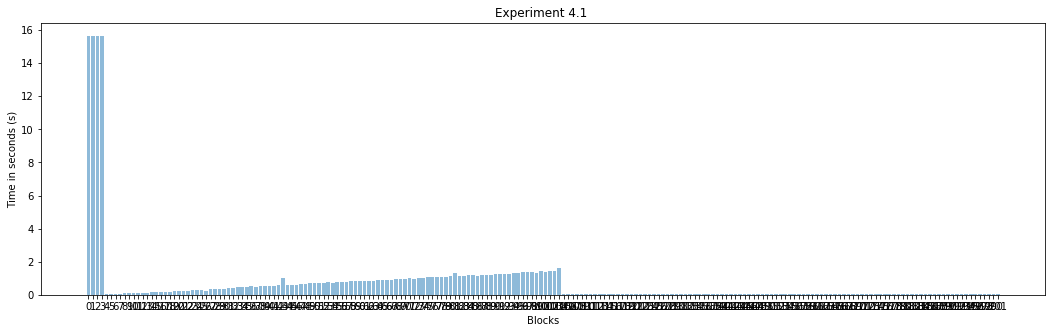

There are 203 Blocks


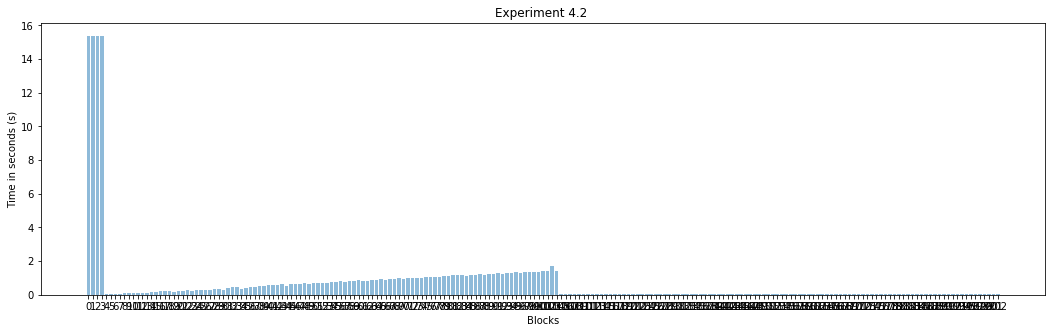

There are 203 Blocks


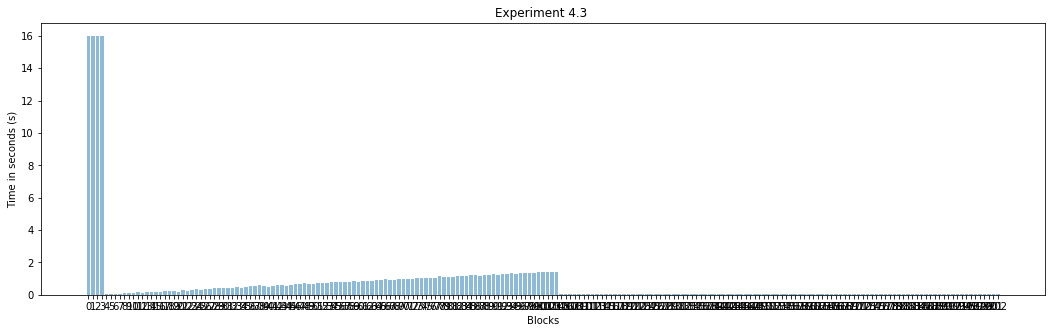

There are 203 Blocks


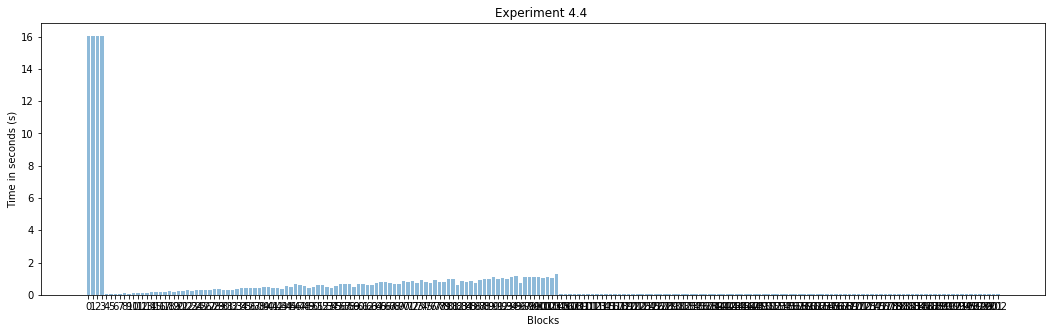

In [25]:
for j in range(1, 5):
    blocks = []
    print("There are %s Blocks"%len(experiment4Results[j-1]))
    for i in range(len(experiment4Results[j-1])):
        blocks.append(str(i))

    propogation_time= experiment4Results[j-1]
    y_pos = np.arange(len(propogation_time))
    plt.subplots(figsize=(18,5))
    plt.bar(y_pos, propogation_time, width=.8, align='center', alpha=0.5 )
    plt.xticks(y_pos, blocks)
    plt.ylabel('Time in seconds (s)')
    plt.xlabel('Blocks')
    plt.title('Experiment 4.%s '% j)

    plt.show()

4
{0: [17.972, 17.977, 17.986, 17.989], 1: [15.713, 15.702, 15.706, 15.705], 2: [18.284, 18.288, 18.291, 18.294], 3: [16.462, 16.45, 16.461, 16.461]}
4
{0: [16.708, 16.696, 16.701, 16.698], 1: [17.669, 17.661, 17.667, 17.666], 2: [16.137, 16.122, 16.128, 16.131], 3: [16.098, 16.08, 16.08, 16.079]}
4
{0: [18.193, 18.189, 18.195, 18.195], 1: [0.898, 0.894, 0.895, 0.893], 2: [19.406, 19.406, 19.409, 19.413], 3: [0.853, 0.855, 0.859, 0.865]}
4
{0: [15.641, 15.619, 15.623, 15.619], 1: [15.369, 15.354, 15.352, 15.353], 2: [16.0, 15.983, 15.982, 15.978], 3: [16.046, 16.023, 16.022, 16.025]}


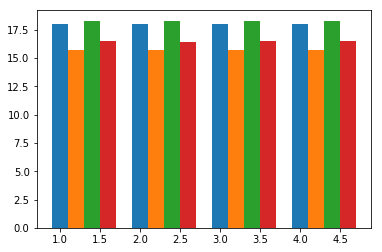

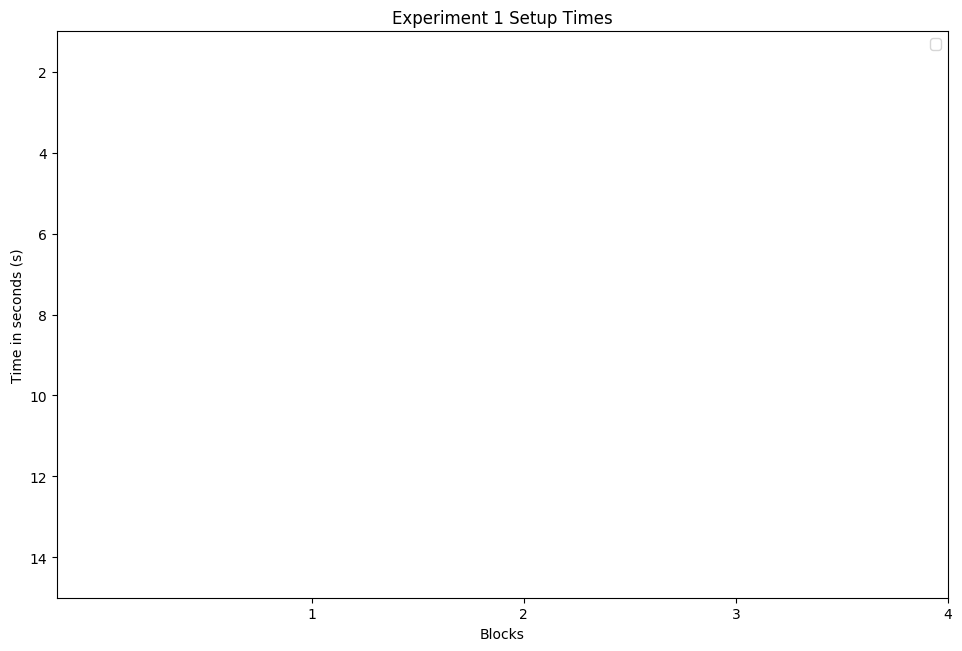

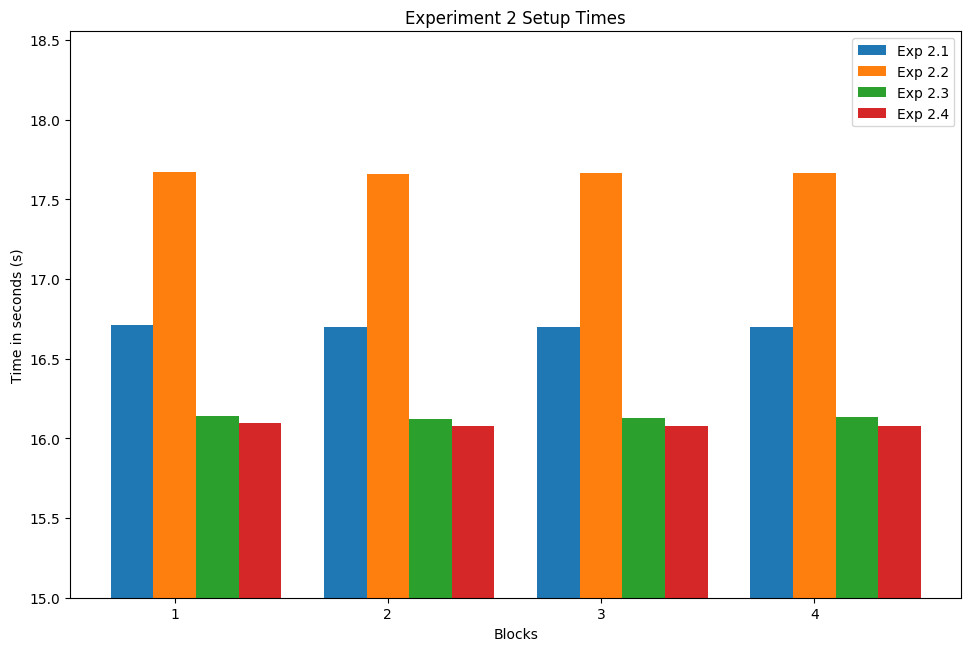

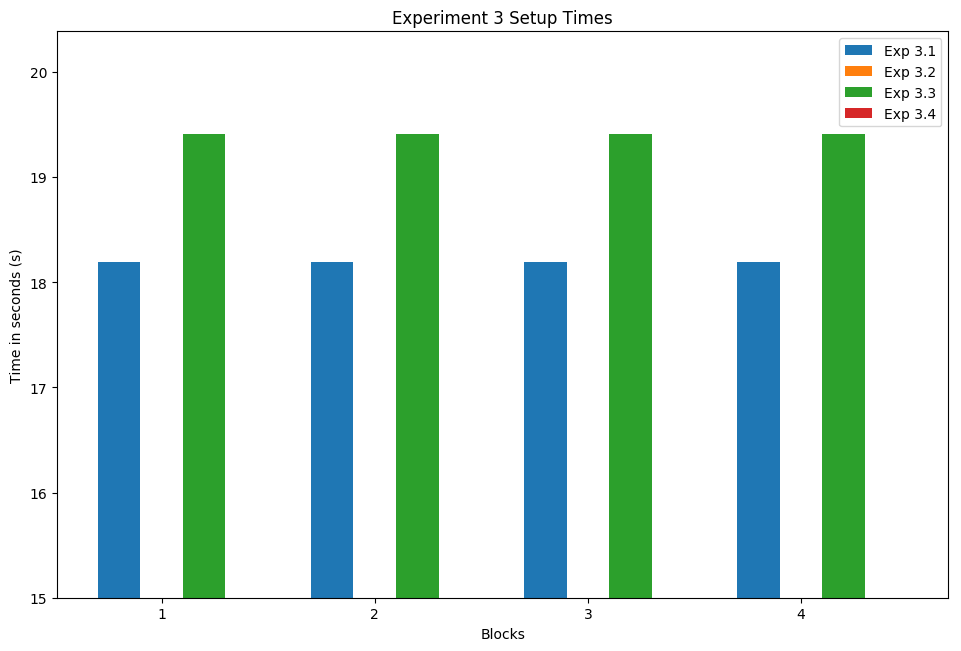

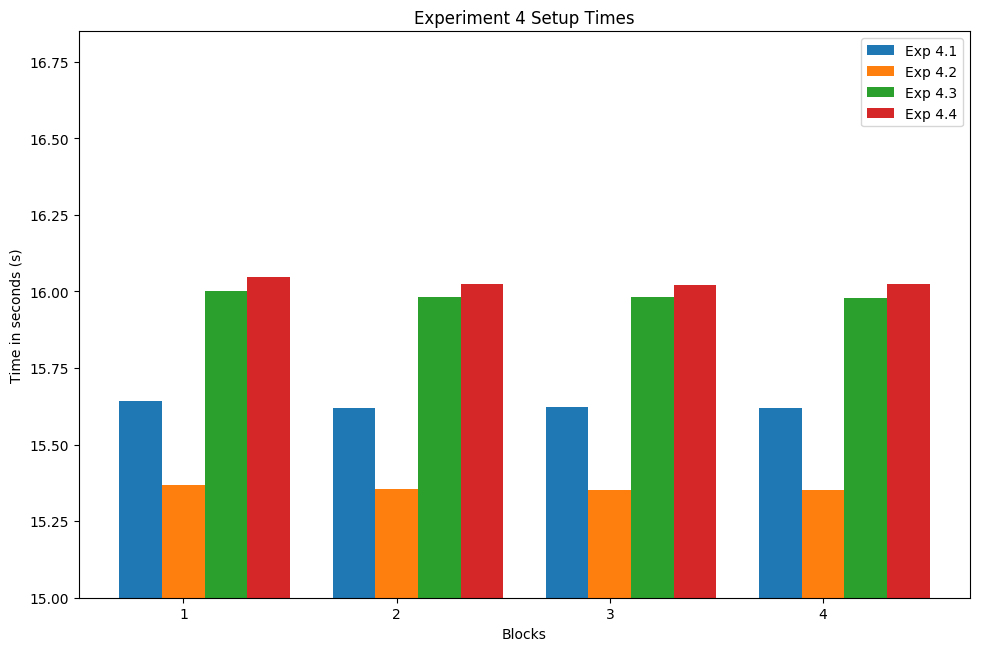

<Figure size 1150x750 with 0 Axes>

In [26]:
#Graphs to show setup times

print(len(experiment1Results))
setup_blocks = {}
for i in range(4):
    setup_blocks[i] = experiment1Results[i][:4]

exp1fig1,( ax1 )= plt.subplots(1,1)
plt.figure(figsize=(11.5, 7.5), dpi=100)

print(setup_blocks)
# plt.subplots(figsize=(18,5))
# for i in range(4):
#     plt.bar([1,2,3,4], setup_blocks[i] )
legend_plot = []
width = 0.20
index = [1,2,3,4]
legend_plot.append(ax1.bar(index, setup_blocks[0], width, label = 'Exp 1.1'))
legend_plot.append(ax1.bar([i+width for i in index], setup_blocks[1], width, label = 'Exp 1.2'))
legend_plot.append(ax1.bar([i+width+width for i in index], setup_blocks[2], width, label = 'Exp 1.3'))
legend_plot.append(ax1.bar([i+width*3 for i in index], setup_blocks[3], width, label = 'Exp 1.4'))
plt.xticks([i+width for i in index],[1,2,3,4])
plt.ylim(15,)
plt.ylabel('Time in seconds (s)')
plt.xlabel('Blocks')
plt.title('Experiment 1 Setup Times')
plt.legend(loc='best')
plt.figure(figsize=(11.5, 7.5), dpi=100)
plt.savefig('Setup_time_Exp1.png', dpi=1000)
# plt.legend(legend_plot, ["Exp 1.1", "Exp 1.2", "Exp 1.4", "Exp 1.3"])
# plt.show()


print(len(experiment2Results))
setup_blocks = {}
for i in range(4):
    setup_blocks[i] = experiment2Results[i][:4]

print(setup_blocks)
# plt.subplots(figsize=(18,5))
# for i in range(4):
#     plt.bar([1,2,3,4], setup_blocks[i] )
legend_plot = []
width = 0.20
index = [1,2,3,4]
legend_plot.append(plt.bar(index, setup_blocks[0], width, label = 'Exp 2.1'))
legend_plot.append(plt.bar([i+width for i in index], setup_blocks[1], width, label = 'Exp 2.2'))
legend_plot.append(plt.bar([i+width+width for i in index], setup_blocks[2], width, label = 'Exp 2.3'))
legend_plot.append(plt.bar([i+width*3 for i in index], setup_blocks[3], width, label = 'Exp 2.4'))
plt.xticks([i+width for i in index],[1,2,3,4])
plt.ylim(15,)
plt.ylabel('Time in seconds (s)')
plt.xlabel('Blocks')
plt.title('Experiment 2 Setup Times')
plt.legend(loc='best')
plt.figure(figsize=(11.5, 7.5), dpi=100)
plt.savefig('Setup_time_Exp2.png', dpi=1000)
# plt.legend(legend_plot, ["Exp 1.1", "Exp 1.2", "Exp 1.4", "Exp 1.3"])
# plt.show()

print(len(experiment3Results))
setup_blocks = {}
for i in range(4):
    setup_blocks[i] = experiment3Results[i][:4]

print(setup_blocks)
# plt.subplots(figsize=(18,5))
# for i in range(4):
#     plt.bar([1,2,3,4], setup_blocks[i] )
legend_plot = []
width = 0.20
index = [1,2,3,4]
legend_plot.append(plt.bar(index, setup_blocks[0], width, label = 'Exp 3.1'))
legend_plot.append(plt.bar([i+width for i in index], setup_blocks[1], width, label = 'Exp 3.2'))
legend_plot.append(plt.bar([i+width+width for i in index], setup_blocks[2], width, label = 'Exp 3.3'))
legend_plot.append(plt.bar([i+width*3 for i in index], setup_blocks[3], width, label = 'Exp 3.4'))
plt.xticks([i+width for i in index],[1,2,3,4])
plt.ylim(15,)
plt.ylabel('Time in seconds (s)')
plt.xlabel('Blocks')
plt.title('Experiment 3 Setup Times')
plt.legend(loc='best')
plt.figure(figsize=(11.5, 7.5), dpi=100)
plt.savefig('Setup_time_Exp3.png', dpi=1000)

# plt.legend(legend_plot, ["Exp 1.1", "Exp 1.2", "Exp 1.4", "Exp 1.3"])
# plt.show()

print(len(experiment4Results))
setup_blocks = {}
for i in range(4):
    setup_blocks[i] = experiment4Results[i][:4]

print(setup_blocks)
# plt.subplots(figsize=(18,5))
# for i in range(4):
#     plt.bar([1,2,3,4], setup_blocks[i] )
legend_plot = []
width = 0.20
index = [1,2,3,4]
legend_plot.append(plt.bar(index, setup_blocks[0], width, label = 'Exp 4.1'))
legend_plot.append(plt.bar([i+width for i in index], setup_blocks[1], width, label = 'Exp 4.2'))
legend_plot.append(plt.bar([i+width+width for i in index], setup_blocks[2], width, label = 'Exp 4.3'))
legend_plot.append(plt.bar([i+width*3 for i in index], setup_blocks[3], width, label = 'Exp 4.4'))
plt.xticks([i+width for i in index],[1,2,3,4])
plt.ylim(15,)
plt.ylabel('Time in seconds (s)')
plt.xlabel('Blocks')
plt.title('Experiment 4 Setup Times')
plt.legend(loc='best')
plt.figure(figsize=(11.5, 7.5), dpi=100)
plt.savefig('Setup_time_Exp4.png', dpi=1000)

# plt.legend(legend_plot, ["Exp 1.1", "Exp 1.2", "Exp 1.4", "Exp 1.3"])
# plt.show()

4
203
181
201
69
4
203
203
203
203
4
203
203
203
203
4
202
203
203
203


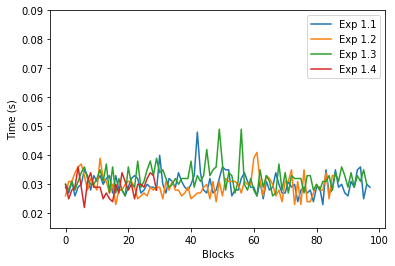

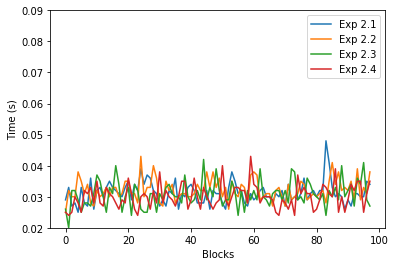

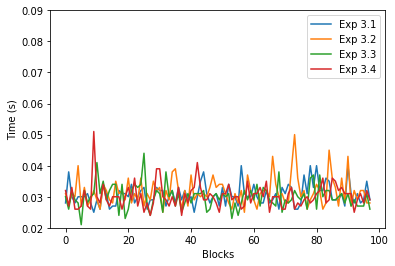

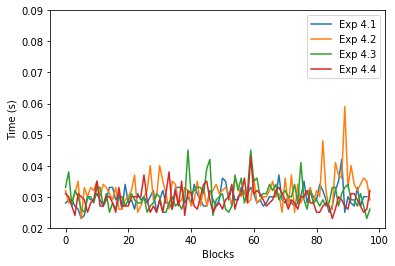

In [28]:
# exp1fig1,( ax1 )= plt.subplots(1,1)
# #     exp1fig2, ax2 = plt.subplots()
# #     exp1fig3, ax3 = plt.subplots()
# #     exp1fig1.suptitle('This is a somewhat long figure title', fontsize=16)
# width = 0.20
# index = [1,2,3,4]
# ax1.bar(index, setup_blocks[0], width, label = 'Exp 1.1')
# ax1.bar([i+width for i in index], setup_blocks[1], width, label = 'Exp 1.2')
# ax1.bar([i+width+width for i in index], setup_blocks[2], width, label = 'Exp 1.3')
# ax1.bar([i+width*3 for i in index], setup_blocks[3], width, label = 'Exp 1.4')
# ax1.legend(loc='best', framealpha= 0.5)
# ax1.set_ylabel('Time in seconds (s)')
# ax1.set_xlabel('Blocks')
# ax1.set_title('')
# ax1.set_xticks([i+width*2 for i in index])
# ax1.set_xticklabels(index)
# ax1.set_ylim(15,)
# exp1fig1.savefig("Setup_time_Exp1.png")
#Read times
print(len(experiment1Results))
exp1fig1,( ax1 )= plt.subplots(1,1)
setup_blocks = {}
for i in range(4):
    setup_blocks[i] = experiment1Results[i][:]
    print(len(setup_blocks[i]))
setup_blocks[0] = experiment1Results[0][105:]
setup_blocks[1] = experiment1Results[1][94:]
setup_blocks[2] = experiment1Results[2][104:]
setup_blocks[3] = experiment1Results[3][39:]
ax1.set_ylabel('Time (s)')
ax1.set_xlabel('Blocks')
# ax1.title('Experiment 1 Read Times')
ax1.plot([i for i in range(len(setup_blocks[0]))],setup_blocks[0], label = 'Exp 1.1')
ax1.plot([i for i in range(len(setup_blocks[1]))],setup_blocks[1], label = 'Exp 1.2')
ax1.plot([i for i in range(len(setup_blocks[2]))],setup_blocks[2], label = 'Exp 1.3')
ax1.plot([i for i in range(len(setup_blocks[3]))],setup_blocks[3], label = 'Exp 1.4')
ax1.legend(loc='best')
ax1.set_ylim(0.015,0.09)
exp1fig1.savefig("Scheme_1_Read_time_Exp1.png")
# plt.show()

print(len(experiment2Results))
exp2fig2,( ax2 )= plt.subplots(1,1)
setup_blocks = {}
for i in range(4):
    setup_blocks[i] = experiment2Results[i][:]
    print(len(setup_blocks[i]))
setup_blocks[0] = experiment2Results[0][105:]
setup_blocks[1] = experiment2Results[1][105:]
setup_blocks[2] = experiment2Results[2][105:]
setup_blocks[3] = experiment2Results[3][105:]
ax2.set_ylabel('Time (s)')
ax2.set_xlabel('Blocks')
# ax2.title('Experiment 2 Read Times')
ax2.plot([i for i in range(len(setup_blocks[0]))],setup_blocks[0], label = 'Exp 2.1')
ax2.plot([i for i in range(len(setup_blocks[1]))],setup_blocks[1], label = 'Exp 2.2')
ax2.plot([i for i in range(len(setup_blocks[2]))],setup_blocks[2], label = 'Exp 2.3')
ax2.plot([i for i in range(len(setup_blocks[3]))],setup_blocks[3], label = 'Exp 2.4')
ax2.legend(loc='best')
ax2.set_ylim(0.020,0.09)
exp2fig2.savefig("Scheme_1_Read_time_Exp2.png")

# ax2.show()

print(len(experiment3Results))
exp3fig3,( ax3 )= plt.subplots(1,1)
setup_blocks = {}
for i in range(4):
    setup_blocks[i] = experiment3Results[i][:]
    print(len(setup_blocks[i]))
setup_blocks[0] = experiment3Results[0][105:]
setup_blocks[1] = experiment3Results[1][105:]
setup_blocks[2] = experiment3Results[2][105:]
setup_blocks[3] = experiment3Results[3][105:]
ax3.set_ylabel('Time (s)')
ax3.set_xlabel('Blocks')
# ax3.title('Experiment 3 Read Times')
ax3.plot([i for i in range(len(setup_blocks[0]))],setup_blocks[0], label = 'Exp 3.1')
ax3.plot([i for i in range(len(setup_blocks[1]))],setup_blocks[1], label = 'Exp 3.2')
ax3.plot([i for i in range(len(setup_blocks[2]))],setup_blocks[2], label = 'Exp 3.3')
ax3.plot([i for i in range(len(setup_blocks[3]))],setup_blocks[3], label = 'Exp 3.4')
ax3.legend(loc='best')
ax3.set_ylim(0.020,0.09)
exp3fig3.savefig("Scheme_1_Read_time_Exp3.png")

# ax3.show()

print(len(experiment4Results))
exp4fig4,( ax4 )= plt.subplots(1,1)
setup_blocks = {}
for i in range(4):
    setup_blocks[i] = experiment4Results[i][:]
    print(len(setup_blocks[i]))
setup_blocks[0] = experiment4Results[0][105:]
setup_blocks[1] = experiment4Results[1][105:]
setup_blocks[2] = experiment4Results[2][105:]
setup_blocks[3] = experiment4Results[3][105:]
ax4.set_ylabel('Time (s)')
ax4.set_xlabel('Blocks')
# ax4.title('Experiment 4 Read Times')
ax4.plot([i for i in range(len(setup_blocks[0]))],setup_blocks[0], label = 'Exp 4.1')
ax4.plot([i for i in range(len(setup_blocks[1]))],setup_blocks[1], label = 'Exp 4.2')
ax4.plot([i for i in range(len(setup_blocks[2]))],setup_blocks[2], label = 'Exp 4.3')
ax4.plot([i for i in range(len(setup_blocks[3]))],setup_blocks[3], label = 'Exp 4.4')
ax4.legend(loc='best')
ax4.set_ylim(0.020,0.09)
exp4fig4.savefig("Scheme_1_Read_time_Exp4.png")

# plt.show()

4
203
181
201
69
4
203
203
203
203
4
203
203
203
203
4
202
203
203
203


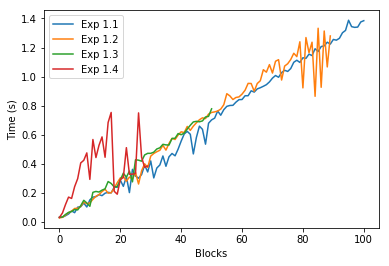

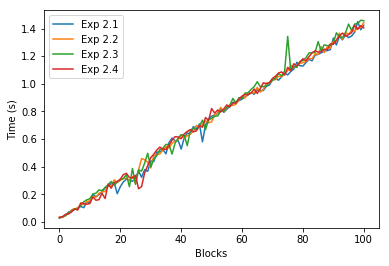

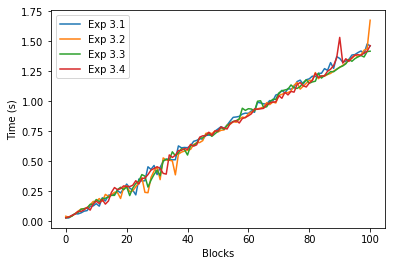

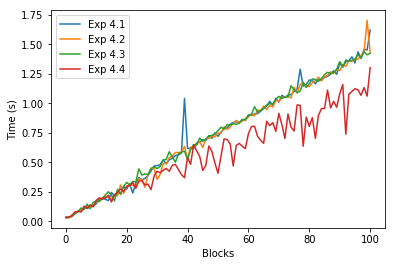

In [29]:
# exp1fig1,( ax1 )= plt.subplots(1,1)
# #     exp1fig2, ax2 = plt.subplots()
# #     exp1fig3, ax3 = plt.subplots()
# #     exp1fig1.suptitle('This is a somewhat long figure title', fontsize=16)
# width = 0.20
# index = [1,2,3,4]
# ax1.bar(index, setup_blocks[0], width, label = 'Exp 1.1')
# ax1.bar([i+width for i in index], setup_blocks[1], width, label = 'Exp 1.2')
# ax1.bar([i+width+width for i in index], setup_blocks[2], width, label = 'Exp 1.3')
# ax1.bar([i+width*3 for i in index], setup_blocks[3], width, label = 'Exp 1.4')
# ax1.legend(loc='best', framealpha= 0.5)
# ax1.set_ylabel('Time in seconds (s)')
# ax1.set_xlabel('Blocks')
# ax1.set_title('')
# ax1.set_xticks([i+width*2 for i in index])
# ax1.set_xticklabels(index)
# ax1.set_ylim(15,)
# exp1fig1.savefig("Setup_time_Exp1.png")

print(len(experiment1Results))
exp1fig1,( ax1 )= plt.subplots(1,1)
setup_blocks = {}
for i in range(4):
    setup_blocks[i] = experiment1Results[i][:]
    print(len(setup_blocks[i]))
setup_blocks[0] = experiment1Results[0][4:105]
setup_blocks[1] = experiment1Results[1][4:94]
setup_blocks[2] = experiment1Results[2][4:55]
setup_blocks[3] = experiment1Results[3][4:34]
ax1.set_ylabel('Time (s)')
ax1.set_xlabel('Blocks')
# plt.title('Experiment 1 Propogation Time for blocks with add_candidate and add_organ transactions')
ax1.plot([i for i in range(len(setup_blocks[0]))],setup_blocks[0], label = 'Exp 1.1')
ax1.plot([i for i in range(len(setup_blocks[1]))],setup_blocks[1], label = 'Exp 1.2')
ax1.plot([i for i in range(len(setup_blocks[2]))],setup_blocks[2], label = 'Exp 1.3')
ax1.plot([i for i in range(len(setup_blocks[3]))],setup_blocks[3], label = 'Exp 1.4')
ax1.legend(loc='best')
# plt.tight_layout()
# plt.ylim(0.010,0.09)
# ax1.show()
exp1fig1.savefig("Scheme_1_Write_time_Exp1.png")

print(len(experiment2Results))
exp2fig2,( ax2 )= plt.subplots(1,1)
setup_blocks = {}
for i in range(4):
    setup_blocks[i] = experiment2Results[i][:]
    print(len(setup_blocks[i]))
setup_blocks[0] = experiment2Results[0][4:105]
setup_blocks[1] = experiment2Results[1][4:105]
setup_blocks[2] = experiment2Results[2][4:105]
setup_blocks[3] = experiment2Results[3][4:105]
ax2.set_ylabel('Time (s)')
ax2.set_xlabel('Blocks')
# plt.title('Experiment 2 Propogation Time for blocks with add_candidate and add_organ transactions')
ax2.plot([i for i in range(len(setup_blocks[0]))],setup_blocks[0], label = 'Exp 2.1')
ax2.plot([i for i in range(len(setup_blocks[1]))],setup_blocks[1], label = 'Exp 2.2')
ax2.plot([i for i in range(len(setup_blocks[2]))],setup_blocks[2], label = 'Exp 2.3')
ax2.plot([i for i in range(len(setup_blocks[3]))],setup_blocks[3], label = 'Exp 2.4')
ax2.legend(loc='best')
# plt.ylim(0.010,0.09)
# ax2.show()
exp2fig2.savefig("Scheme_1_Write_time_Exp2.png")

print(len(experiment3Results))
exp3fig3,( ax3 )= plt.subplots(1,1)
setup_blocks = {}
for i in range(4):
    setup_blocks[i] = experiment3Results[i][:]
    print(len(setup_blocks[i]))
setup_blocks[0] = experiment3Results[0][4:105]
setup_blocks[1] = experiment3Results[1][4:105]
setup_blocks[2] = experiment3Results[2][4:105]
setup_blocks[3] = experiment3Results[3][4:105]
ax3.set_ylabel('Time (s)')
ax3.set_xlabel('Blocks')
# plt.title('Experiment 3 Propogation Time for blocks with add_candidate and add_organ transactions')
ax3.plot([i for i in range(len(setup_blocks[0]))],setup_blocks[0], label = 'Exp 3.1')
ax3.plot([i for i in range(len(setup_blocks[1]))],setup_blocks[1], label = 'Exp 3.2')
ax3.plot([i for i in range(len(setup_blocks[2]))],setup_blocks[2], label = 'Exp 3.3')
ax3.plot([i for i in range(len(setup_blocks[3]))],setup_blocks[3], label = 'Exp 3.4')
ax3.legend(loc='best')
# plt.ylim(0.010,0.09)
# ax3.show()
exp3fig3.savefig("Scheme_1_Write_time_Exp3.png")

print(len(experiment4Results))
exp4fig4,( ax4 )= plt.subplots(1,1)
setup_blocks = {}
for i in range(4):
    setup_blocks[i] = experiment4Results[i][:]
    print(len(setup_blocks[i]))
setup_blocks[0] = experiment4Results[0][4:105]
setup_blocks[1] = experiment4Results[1][4:105]
setup_blocks[2] = experiment4Results[2][4:105]
setup_blocks[3] = experiment4Results[3][4:105]
ax4.set_ylabel('Time (s)')
ax4.set_xlabel('Blocks')
# plt.title('Experiment 4 `Propogation Time for blocks with add_candidate and add_organ transactions')
ax4.plot([i for i in range(len(setup_blocks[0]))],setup_blocks[0], label = 'Exp 4.1')
ax4.plot([i for i in range(len(setup_blocks[1]))],setup_blocks[1], label = 'Exp 4.2')
ax4.plot([i for i in range(len(setup_blocks[2]))],setup_blocks[2], label = 'Exp 4.3')
ax4.plot([i for i in range(len(setup_blocks[3]))],setup_blocks[3], label = 'Exp 4.4')
ax4.legend(loc='best')
# plt.ylim(0.010,0.09)
# ax4.show()
exp4fig4.savefig("Scheme_1_Write_time_Exp4.png")

In [30]:
from matplotlib import pyplot as plt
def plot_with_style(style):
#     plt.style.use(style)
    for i in range(4):
        setup_blocks[i] = experiment1Results[i][:4]

    exp1fig1,( ax1,ax2,ax3 )= plt.subplots(1,3)
#     exp1fig2, ax2 = plt.subplots()
#     exp1fig3, ax3 = plt.subplots()
#     exp1fig1.suptitle('This is a somewhat long figure title', fontsize=16)
    width = 0.20
    index = [1,2,3,4]
    ax1.bar(index, setup_blocks[0], width, label = 'Exp 1.1')
    ax1.bar([i+width for i in index], setup_blocks[1], width, label = 'Exp 1.2')
    ax1.bar([i+width+width for i in index], setup_blocks[2], width, label = 'Exp 1.3')
    ax1.bar([i+width*3 for i in index], setup_blocks[3], width, label = 'Exp 1.4')
    ax1.legend(loc='best', framealpha= 0.5)
    ax1.set_ylabel('Time (s)')
    ax1.set_xlabel('Blocks')
    ax1.set_title('')
    ax1.set_xticks([i+width*2 for i in index])
    ax1.set_xticklabels(index)
    ax1.set_ylim(15,)

    
    
    setup_blocks[0] = experiment1Results[0][105:]
    setup_blocks[1] = experiment1Results[1][94:]
    setup_blocks[2] = experiment1Results[2][104:]
    setup_blocks[3] = experiment1Results[3][39:]
    ax2.plot([i for i in range(len(setup_blocks[0]))],setup_blocks[0], label = 'Exp 1.1')
    ax2.plot([i for i in range(len(setup_blocks[1]))],setup_blocks[1], label = 'Exp 1.2')
    ax2.plot([i for i in range(len(setup_blocks[2]))],setup_blocks[2], label = 'Exp 1.3')
    ax2.plot([i for i in range(len(setup_blocks[3]))],setup_blocks[3], label = 'Exp 1.4')
    ax2.set_ylabel('Time (s)')
    ax2.set_xlabel('Blocks')
    ax2.set_title('')
#     ax2.set_xticks()

    setup_blocks[0] = experiment1Results[0][4:105]
    setup_blocks[1] = experiment1Results[1][4:94]
    setup_blocks[2] = experiment1Results[2][4:55]
    setup_blocks[3] = experiment1Results[3][4:34]
    ax3.plot([i for i in range(len(setup_blocks[0]))],setup_blocks[0], label = 'Exp 1.1')
    ax3.plot([i for i in range(len(setup_blocks[1]))],setup_blocks[1], label = 'Exp 1.2')
    ax3.plot([i for i in range(len(setup_blocks[2]))],setup_blocks[2], label = 'Exp 1.3')
    ax3.plot([i for i in range(len(setup_blocks[3]))],setup_blocks[3], label = 'Exp 1.4')
    ax3.set_ylabel('Time (s)')
    ax3.set_xlabel('Blocks')
    ax3.set_title('')
#     ax3.set_xticks()


    ax1.legend(loc='best', framealpha= .3)


    ax2.legend(loc='best')

    ax3.legend(loc='best')
    exp1fig1.savefig("topo1_exp1.png")
    plt.tight_layout()

    plt.show()

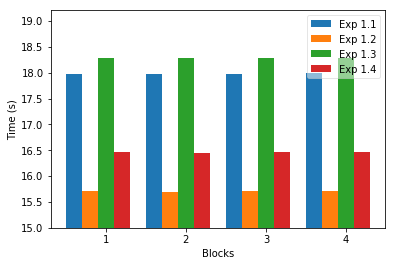

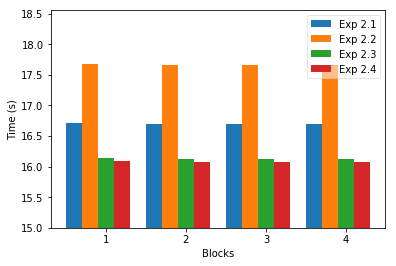

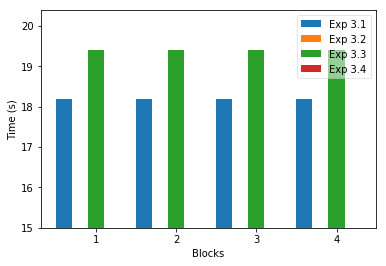

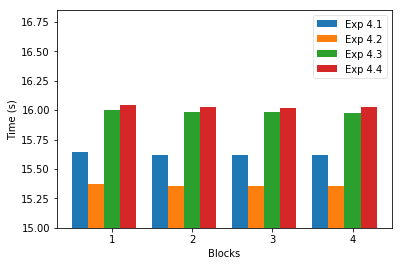

In [31]:
for i in range(4):
        setup_blocks[i] = experiment1Results[i][:4]

exp1fig1,( ax1 )= plt.subplots(1,1)
#     exp1fig2, ax2 = plt.subplots()
#     exp1fig3, ax3 = plt.subplots()
#     exp1fig1.suptitle('This is a somewhat long figure title', fontsize=16)
width = 0.20
index = [1,2,3,4]
ax1.bar(index, setup_blocks[0], width, label = 'Exp 1.1')
ax1.bar([i+width for i in index], setup_blocks[1], width, label = 'Exp 1.2')
ax1.bar([i+width+width for i in index], setup_blocks[2], width, label = 'Exp 1.3')
ax1.bar([i+width*3 for i in index], setup_blocks[3], width, label = 'Exp 1.4')
ax1.legend(loc='best', framealpha= 0.5)
ax1.set_ylabel('Time (s)')
ax1.set_xlabel('Blocks')
ax1.set_title('')
ax1.set_xticks([i+width*2 for i in index])
ax1.set_xticklabels(index)
ax1.set_ylim(15,)
exp1fig1.savefig("Setup_time_Exp1.png")


for i in range(4):
        setup_blocks[i] = experiment2Results[i][:4]

exp2fig2,( ax2 )= plt.subplots(1,1)
#     exp1fig2, ax2 = plt.subplots()
#     exp1fig3, ax3 = plt.subplots()
#     exp1fig1.suptitle('This is a somewhat long figure title', fontsize=16)
width = 0.20
index = [1,2,3,4]
ax2.bar(index, setup_blocks[0], width, label = 'Exp 2.1')
ax2.bar([i+width for i in index], setup_blocks[1], width, label = 'Exp 2.2')
ax2.bar([i+width+width for i in index], setup_blocks[2], width, label = 'Exp 2.3')
ax2.bar([i+width*3 for i in index], setup_blocks[3], width, label = 'Exp 2.4')
ax2.legend(loc='best', framealpha= 0.5)
ax2.set_ylabel('Time (s)')
ax2.set_xlabel('Blocks')
ax2.set_title('')
ax2.set_xticks([i+width*2 for i in index])
ax2.set_xticklabels(index)
ax2.set_ylim(15,)
exp2fig2.savefig("Setup_time_Exp2.png")


for i in range(4):
        setup_blocks[i] = experiment3Results[i][:4]

exp3fig3,( ax3 )= plt.subplots(1,1)
#     exp1fig2, ax2 = plt.subplots()
#     exp1fig3, ax3 = plt.subplots()
#     exp1fig1.suptitle('This is a somewhat long figure title', fontsize=16)
width = 0.20
index = [1,2,3,4]
ax3.bar(index, setup_blocks[0], width, label = 'Exp 3.1')
ax3.bar([i+width for i in index], setup_blocks[1], width, label = 'Exp 3.2')
ax3.bar([i+width+width for i in index], setup_blocks[2], width, label = 'Exp 3.3')
ax3.bar([i+width*3 for i in index], setup_blocks[3], width, label = 'Exp 3.4')
ax3.legend(loc='best', framealpha= 0.5)
ax3.set_ylabel('Time (s)')
ax3.set_xlabel('Blocks')
ax3.set_title('')
ax3.set_xticks([i+width*2 for i in index])
ax3.set_xticklabels(index)
ax3.set_ylim(15,)
exp3fig3.savefig("Setup_time_Exp3.png")


for i in range(4):
        setup_blocks[i] = experiment4Results[i][:4]

exp4fig4,( ax4 )= plt.subplots(1,1)
#     exp1fig2, ax2 = plt.subplots()
#     exp1fig3, ax3 = plt.subplots()
#     exp1fig1.suptitle('This is a somewhat long figure title', fontsize=16)
width = 0.20
index = [1,2,3,4]
ax4.bar(index, setup_blocks[0], width, label = 'Exp 4.1')
ax4.bar([i+width for i in index], setup_blocks[1], width, label = 'Exp 4.2')
ax4.bar([i+width+width for i in index], setup_blocks[2], width, label = 'Exp 4.3')
ax4.bar([i+width*3 for i in index], setup_blocks[3], width, label = 'Exp 4.4')
ax4.legend(loc='best', framealpha= 0.5)
ax4.set_ylabel('Time (s)')
ax4.set_xlabel('Blocks')
ax4.set_title('')
ax4.set_xticks([i+width*2 for i in index])
ax4.set_xticklabels(index)
ax4.set_ylim(15,)
exp4fig4.savefig("Setup_time_Exp4.png")

In [27]:
0: [29.202, 29.212, 29.22, 29.241], 1: [16.116, 16.097, 16.096, 16.097], 2: [15.56, 15.542, 15.547, 15.542], 3: [0.957, 0.959, 0.965, 0.96]

SyntaxError: invalid syntax (<ipython-input-27-bf6364c8222c>, line 1)